In [2]:
import os
import tensorflow as tf
import tensorflow.python.platform
from tensorflow.python.platform import gfile
import numpy as np
import glob

classes = np.array(['ayam_bakar', 'ayam_crispy', 'bakso', 'gado2', 'ikan_bakar', 'mie_goreng', 'nasi_goreng', 'pecel_lele', 'pizza', 'rendang', 'sate', 'soto', 'sushi'])
num_classes = len(classes)
temp = classes.tolist()
 
def create_graph(model_path):
    """
    create_graph loads the inception model to memory, should be called before
    calling extract_features.
 
    model_path: path to inception model in protobuf form.
    """
    with gfile.FastGFile(model_path, 'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
        _ = tf.import_graph_def(graph_def, name='')
        print 'selesai'
 
 
def extract_features(image_paths, verbose=False):
    """
    extract_features computed the inception bottleneck feature for a list of images
 
    image_paths: array of image path
    return: 2-d array in the shape of (len(image_paths), 2048)
    """
    features = []
    cls = []
    
    with tf.Session() as sess:
        flattened_tensor = sess.graph.get_tensor_by_name('pool_3:0')
 
        for fld in classes:
            index = temp.index(fld)
            path = os.path.join(image_paths, fld, '*.jpg')
            files = glob.glob(path)
            
            for fl in files:
                label = np.zeros(len(classes))
                label[index] = 1.0
                print '{0}\r'.format(fl),
                image_data = gfile.FastGFile(fl, 'rb').read()
                feature = sess.run(flattened_tensor, {
                    'DecodeJpeg/contents:0': image_data
                })
                features.append(feature)
                cls.append(label)
                
    return features, cls

In [3]:
path = 'inception_dec_2015/tensorflow_inception_graph.pb'
create_graph(path)

selesai


In [4]:
image_paths = 'data_training/'
images, cls = extract_features(image_paths, verbose=False)
print "selesai"

selesaiaining/sushi/sushi_t1 (82).jpggjpgpg


In [5]:
image_paths = 'data_testing/'
images_test, cls_test = extract_features(image_paths, verbose=False)
print "selesai"

selesaisting/sushi/sushi (12).jpgpy).jpg


In [6]:
print len(images)
print len(images_test)
num_sample = len(images)
num_test = len(images_test)

5359
300


(1, 1, 1, 2048)


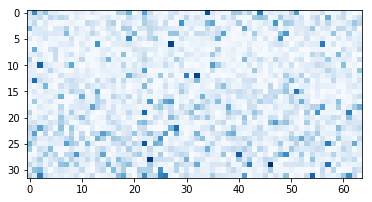

In [7]:
img = np.asarray(images[700])
print img.shape
img = img.reshape((32,64))

import matplotlib.pyplot as plt
# Plot the image for the transfer-values.
plt.imshow(img, interpolation='nearest', cmap='Blues')
plt.show()

In [8]:
transfer_values = np.asarray(images)
transfer_values = transfer_values.reshape((num_sample,2048))
print transfer_values.shape

transfer_values_test = np.asarray(images_test)
transfer_values_test = transfer_values_test.reshape((num_test,2048))
print transfer_values_test.shape



(5359, 2048)
(300, 2048)


In [9]:
cls = np.asarray(cls)
cls = cls.astype(int)
print cls.shape

cls_test = np.asarray(cls_test)
cls_test = cls_test.astype(int)
print cls_test.shape

(5359, 13)
(300, 13)


In [10]:
print cls

[[1 0 0 ..., 0 0 0]
 [1 0 0 ..., 0 0 0]
 [1 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 1]
 [0 0 0 ..., 0 0 1]
 [0 0 0 ..., 0 0 1]]


In [11]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
transfer_values_reduced = pca.fit_transform(transfer_values)


In [12]:
def plot_scatter(values, cls):
    # Create a color-map with a different color for each class.
    import matplotlib.cm as cm
    cmap = cm.rainbow(np.linspace(0.0, 1.0, num_classes))

    # Get the color for each sample.
    colors = cmap[cls]

    # Extract the x- and y-values.
    x = values[:, 0]
    y = values[:, 1]

    # Plot it.
    plt.scatter(x, y, color=colors)
    plt.show()

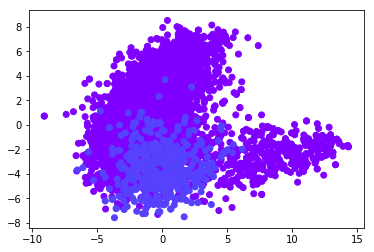

In [13]:
num_features = len(transfer_values[0])
plot_scatter(transfer_values_reduced, cls[:,12])

(5359,)
(5359,)


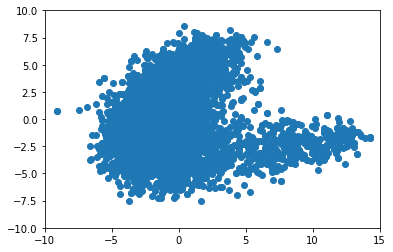

In [14]:
x = transfer_values_reduced[:,0]
print x.shape
y = transfer_values_reduced[:,1]
print y.shape
plt.scatter(x,y)
plt.xlim(-10, 15)
plt.ylim(-10, 10)
plt.show()

In [15]:
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))
def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))

def new_fc_layer(input,          # The previous layer.
                 num_inputs,     # Num. inputs from prev. layer.
                 num_outputs,    # Num. outputs.
                 use_relu=True): # Use Rectified Linear Unit (ReLU)?

    # Create new weights and biases.
    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)

    # Calculate the layer as the matrix multiplication of
    # the input and weights, and then add the bias-values.
    layer = tf.matmul(input, weights) + biases

    # Use ReLU?
    if use_relu:
        layer = tf.nn.relu(layer)

    return layer

feature_size_flat = num_features
x = tf.placeholder(tf.float32, shape=[None, feature_size_flat], name='x')
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')
y_true_cls = tf.argmax(y_true, dimension=1)


layer_fc1 = new_fc_layer(input= x,
                         num_inputs=num_features,
                         num_outputs=1000,
                         use_relu=True)
layer_fc2 = new_fc_layer(input=layer_fc1,
                         num_inputs=1000,
                         num_outputs=num_classes,
                         use_relu=False)
y_pred = tf.nn.softmax(layer_fc2)
y_pred_cls = tf.argmax(y_pred, dimension=1)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc2,
                                                        labels=y_true)
cost = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))



In [16]:
train_acc = []
test_acc = []

In [17]:
import time
from datetime import timedelta
from sklearn.utils import shuffle

session = tf.Session()
session.run(tf.global_variables_initializer())
save_path = "the_model/food_model"
saver = tf.train.Saver()

train_batch = 50

def optimize(num_iterations):
    global transfer_values
    global cls
    global transfer_values_test
    global cls_test
    
    # Start-time used for printing time-usage below.
    start_time = time.time()
    
    best_acc_test = 0.0
    best_train_acc = 0.0
    
    batch_ke = 0

    for i in range(num_iterations):
        batch_ke += 1
       
        # Get a batch of training examples.
        # x_batch now holds a batch of images and
        # y_true_batch are the true labels for those images.
        if (batch_ke * train_batch < num_sample ):
            batas_bawah = (batch_ke - 1) * train_batch
            batas_atas = batch_ke * train_batch
            x_batch = transfer_values[batas_bawah : batas_atas]
            y_batch = cls[batas_bawah : batas_atas]
        else :
            batch_ke = 1
            transfer_values, cls = shuffle(transfer_values, cls)
            batas_bawah = (batch_ke - 1) * train_batch
            batas_atas = batch_ke * train_batch
            x_batch = transfer_values[batas_bawah : batas_atas]
            y_batch = cls[batas_bawah : batas_atas]
            
        # Put the batch into a dict with the proper names
        # for placeholder variables in the TensorFlow graph.
        feed_dict_train = {x: x_batch,
                           y_true: y_batch}
        

        # Run the optimizer using this batch of training data.
        # TensorFlow assigns the variables in feed_dict_train
        # to the placeholder variables and then runs the optimizer.
        session.run(optimizer, feed_dict=feed_dict_train)
        # Print the accuracy.
        msg = "eopch: {0:>6}, train accuracy:{1:>6.1%}, test accuracy:{2:>6.1%} {3}"

        # Print status at end of each epoch (defined as full pass through training dataset).
        if i % 1 == 0:
            acc = session.run(accuracy, feed_dict=feed_dict_train)
            
            ## testing model
            acc_test = 0
            for j in range(6):
                batas_bawah = j * train_batch
                batas_atas = (j + 1) * train_batch
                x_batch_test = transfer_values_test[batas_bawah : batas_atas]
                y_batch_test = cls_test[batas_bawah : batas_atas]
                feed_dict_test = {x: x_batch_test,
                        y_true: y_batch_test}
                acc_test += session.run(accuracy, feed_dict=feed_dict_test)
                    
            acc_test = acc_test/6
            
            # appending list
            train_acc.append(acc)
            test_acc.append(acc_test)
            
            if (acc_test > best_acc_test) :
                saver.save(sess=session, save_path=save_path)
                #best_val_loss = val_loss
                #best_val_acc = acc_val
                best_acc_test = acc_test
                sign = "*"
                print msg.format(i,acc, acc_test, sign)
            else:
                sign = "-"
                print msg.format(i, acc, acc_test, sign) 

    # Ending time.
    end_time = time.time()

    # Difference between start and end-times.
    time_dif = end_time - start_time

    # Print the time-usage.
    print("Time elapsed: " + str(timedelta(seconds=int(round(time_dif)))))

In [18]:
optimize(num_iterations=5000)

eopch:      0, train accuracy:  4.0%, test accuracy:  8.7% *
eopch:      1, train accuracy: 74.0%, test accuracy:  5.7% -
eopch:      2, train accuracy:100.0%, test accuracy:  7.3% -
eopch:      3, train accuracy:100.0%, test accuracy:  7.3% -
eopch:      4, train accuracy:100.0%, test accuracy:  7.3% -
eopch:      5, train accuracy:100.0%, test accuracy:  7.3% -
eopch:      6, train accuracy:100.0%, test accuracy:  7.3% -
eopch:      7, train accuracy:100.0%, test accuracy:  7.3% -
eopch:      8, train accuracy:100.0%, test accuracy:  7.3% -
eopch:      9, train accuracy:100.0%, test accuracy:  7.3% -
eopch:     10, train accuracy:  4.0%, test accuracy:  7.3% -
eopch:     11, train accuracy:  0.0%, test accuracy:  7.3% -
eopch:     12, train accuracy:  0.0%, test accuracy:  7.3% -
eopch:     13, train accuracy:  0.0%, test accuracy:  7.3% -
eopch:     14, train accuracy:  0.0%, test accuracy:  7.3% -
eopch:     15, train accuracy:  0.0%, test accuracy:  7.3% -
eopch:     16, train acc

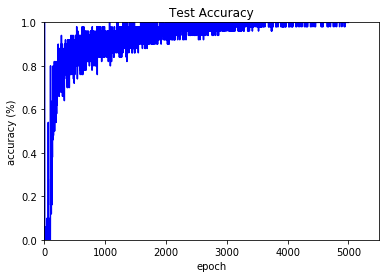

In [45]:
plt.plot(train_acc, color = 'blue')
plt.title('Test Accuracy')
plt.xlim(0, 5500)
plt.ylim(0, 1)
plt.xlabel('epoch')
plt.ylabel('accuracy (%)')
plt.show()

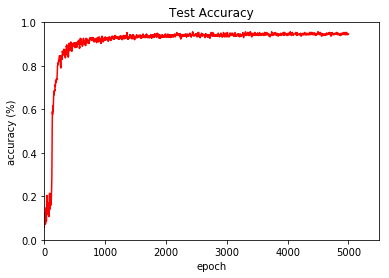

In [44]:
plt.plot(test_acc, color = 'red')
plt.title('Test Accuracy')
plt.xlim(0, 5500)
plt.ylim(0, 1)
plt.xlabel('epoch')
plt.ylabel('accuracy (%)')
plt.show()

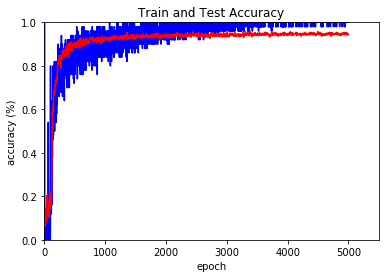

In [51]:
plt.figure(1)
plt.title('Train and Test Accuracy')
plt.plot(train_acc, color = 'blue')
plt.xlim(0, 5500)
plt.ylim(0, 1)
plt.xlabel('epoch')
plt.ylabel('accuracy (%)')

plt.figure(1)
plt.plot(test_acc, color = 'red')
plt.xlim(0, 5500)
plt.ylim(0, 1)

plt.show()


In [53]:
def plot_confusion_matrix(cls_pred):
    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Get the true classifications for the test-set.
    cls_true = data.valid.cls
    
    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)

    # Print the confusion matrix as text.
    print(cm)

    # Plot the confusion matrix as an image.
    plt.matshow(cm)

    # Make various adjustments to the plot.
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')

    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()
    
def plot_example_errors(cls_pred, correct):
    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # correct is a boolean array whether the predicted class
    # is equal to the true class for each image in the test-set.

    # Negate the boolean array.
    incorrect = (correct == False)
    
    # Get the images from the test-set that have been
    # incorrectly classified.
    images = data.valid.images[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = data.valid.cls[incorrect]
    
    # Plot the first 9 images.
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

In [59]:
def print_validation_accuracy(show_example_errors=False,
                        show_confusion_matrix=False):

    # Allocate an array for the predicted classes which
    # will be calculated in batches and filled into this array.
    cls_pred = np.zeros(shape=num_test, dtype=np.int)

    # Now calculate the predicted classes for the batches.
    # We will just iterate through all the batches.
    # There might be a more clever and Pythonic way of doing this.

    # The starting index for the next batch is denoted i.
    i = 0

    while i < num_test:
        # The ending index for the next batch is denoted j.
        j = min(i + 50, num_test)

        # Get the images from the test-set between index i and j.
        images = data.valid.images[i:j, :].reshape(batch_size, img_size_flat)
        

        # Get the associated labels.
        labels = data.valid.labels[i:j, :]

        # Create a feed-dict with these images and labels.
        feed_dict = {x: images,
                     y_true: labels}

        # Calculate the predicted class using TensorFlow.
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)

        # Set the start-index for the next batch to the
        # end-index of the current batch.
        i = j

    cls_true = np.array(data.valid.cls)
    cls_pred = np.array([classes[x] for x in cls_pred]) 

    # Create a boolean array whether each image is correctly classified.
    correct = (cls_true == cls_pred)

    # Calculate the number of correctly classified images.
    # When summing a boolean array, False means 0 and True means 1.
    correct_sum = correct.sum()

    # Classification accuracy is the number of correctly classified
    # images divided by the total number of images in the test-set.
    acc = float(correct_sum) / num_test

    # Print the accuracy.
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_test))

    # Plot some examples of mis-classifications, if desired.
    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)

    # Plot the confusion matrix, if desired.
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)

ValueError: Cannot feed value of shape (2048,) for Tensor u'x:0', which has shape '(?, 2048)'

In [60]:
print tensor_values

NameError: name 'tensor_values' is not defined